<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IRIS" data-toc-modified-id="IRIS-1">IRIS</a></span></li><li><span><a href="#TITANIC" data-toc-modified-id="TITANIC-2">TITANIC</a></span><ul class="toc-item"><li><span><a href="#Prepro" data-toc-modified-id="Prepro-2.1">Prepro</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2.2">Model</a></span><ul class="toc-item"><li><span><a href="#Interpretability" data-toc-modified-id="Interpretability-2.2.1">Interpretability</a></span></li></ul></li><li><span><a href="#Other-Model" data-toc-modified-id="Other-Model-2.3">Other Model</a></span><ul class="toc-item"><li><span><a href="#Interpretability" data-toc-modified-id="Interpretability-2.3.1">Interpretability</a></span></li></ul></li><li><span><a href="#MODEL-FROM-SHAP-(LGB)" data-toc-modified-id="MODEL-FROM-SHAP-(LGB)-2.4">MODEL FROM SHAP (LGB)</a></span><ul class="toc-item"><li><span><a href="#AUTRES---------------" data-toc-modified-id="AUTRES----------------2.4.1">AUTRES --------------</a></span></li></ul></li></ul></li></ul></div>

# IRIS

In [2]:
import seaborn as sns
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

In [3]:
df_iris = sns.load_dataset('iris')
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
X = df_iris.iloc[:,:-1]
y = df_iris.iloc[:,-1]

In [5]:
lgbm = LGBMClassifier()
lgbm.fit(X, y)

LGBMClassifier()

In [6]:
N = 50
my_X = df_iris.iloc[N:N+1,:-1]
lgbm.predict_proba(my_X), df_iris.iloc[N,-1]

(array([[4.28717368e-06, 9.99982856e-01, 1.28568726e-05]]), 'versicolor')

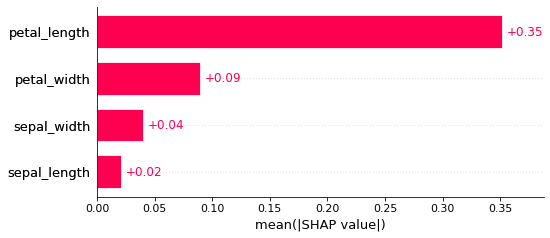

In [7]:
import shap

# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(lgbm.predict_proba, X)
shap_values = explainer(X.iloc[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,0]
shap.plots.bar(shap_values)

# TITANIC

In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.rcParams['figure.facecolor']='w'

import catboost
print('catboost version:', catboost.__version__)
from catboost import CatBoostClassifier 
 

catboost version: 0.24.3


## Prepro

In [9]:
titanic_df = pd.read_csv('titanic3.csv')
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [10]:
# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U') 
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown') 
 
# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First', 
                                np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))


titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown') 

# impute age to mean
titanic_df['age'] = titanic_df['age'].fillna(titanic_df['age'].mean())
titanic_df['age']

titanic_df['fare'] = titanic_df['fare'].fillna(np.mean(titanic_df['fare']))


titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,isfemale
0,First,1,29.00,0,0,211.3375,B,S,1
1,First,1,0.92,1,2,151.5500,C,S,0
2,First,0,2.00,1,2,151.5500,C,S,1
3,First,0,30.00,1,2,151.5500,C,S,0
4,First,0,25.00,1,2,151.5500,C,S,1


In [11]:
# map categorical features

titanic_catboost_ready_df = titanic_df.dropna() 

features = [feat for feat in list(titanic_catboost_ready_df) 
            if feat != 'survived']
print(features)
categorical_features = np.where(titanic_catboost_ready_df[features].dtypes != np.float)[0]
 

X_train, X_test, y_train, y_test = train_test_split(titanic_df[features], 
                                                    titanic_df[['survived']], 
                                                    test_size=0.3, 
                                                     random_state=1)
 


['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'isfemale']


## Model

In [12]:
params = {'iterations':5000,
        'learning_rate':0.01,
        'cat_features':categorical_features,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 1
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train,   
          eval_set=(X_test, y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8293479	best: 0.8293479 (0)	total: 70.5ms	remaining: 5m 52s
200:	test: 0.8404944	best: 0.8407104 (192)	total: 1.77s	remaining: 42.3s
400:	test: 0.8433418	best: 0.8441785 (338)	total: 3.54s	remaining: 40.6s
600:	test: 0.8450691	best: 0.8451770 (599)	total: 5.21s	remaining: 38.1s
800:	test: 0.8480649	best: 0.8480919 (797)	total: 6.87s	remaining: 36s
1000:	test: 0.8495763	best: 0.8495763 (1000)	total: 8.57s	remaining: 34.2s
1200:	test: 0.8514520	best: 0.8515600 (1191)	total: 10.3s	remaining: 32.7s
1400:	test: 0.8526665	best: 0.8530174 (1371)	total: 12.1s	remaining: 31.1s
1600:	test: 0.8543398	best: 0.8543398 (1560)	total: 14s	remaining: 29.7s
1800:	test: 0.8546907	best: 0.8548526 (1754)	total: 15.8s	remaining: 28.1s
2000:	test: 0.8546097	best: 0.8550416 (1808)	total: 17.5s	remaining: 26.3s
2200:	test: 0.8555813	best: 0.8556083 (2191)	total: 19.4s	remaining: 24.7s
2400:	test: 0.8546502	best: 0.8557163 (2213)	total: 21.3s	remaining: 23s
2600:	test: 0.8536786	best: 0.8557163 (2213

### Interpretability

In [13]:
import shap  # package used to calculate Shap values
# SHapley Additive exPlanations
# The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. 

from catboost import CatBoostClassifier, Pool

shap_values = cat_model.get_feature_importance(Pool(X_test,
                                                    label=y_test,
                                                    cat_features=categorical_features),
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value,
                shap_values[0,:],
                X_test.iloc[0,:])

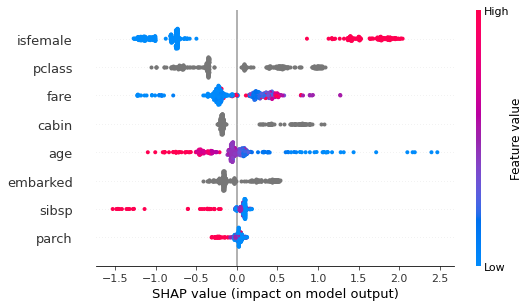

In [14]:
shap.summary_plot(shap_values, X_test)

## Other Model

In [15]:
ct = CustTransformer(thresh_card=8,
                     strat_binary='ord',
                     strat_low_card='ohe',
                     strat_high_card='loo',
                     strat_quant='stand')

ct.fit(X_train, y_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

NameError: name 'CustTransformer' is not defined

In [ ]:
X_train_enc.shape, X_train.shape, X_test_enc.shape, X_test.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=14)
rf_clf.fit(X_train_enc, y_train['survived'])

### Interpretability

In [ ]:
feat_imp_df = pd.DataFrame(rf_clf.feature_importances_,
                           index=X_train_enc.columns,
                          columns= ['feat_imp']).sort_values('feat_imp', ascending=False)
feat_imp_df.plot.bar()

In [1]:
import shap

# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(rf_clf.predict_proba, X_train_enc)
shap_values = explainer(X_train_enc.iloc[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,0]
shap.plots.bar(shap_values)

NameError: name 'rf_clf' is not defined

In [ ]:
shap_values = explainer(X_train_enc.iloc[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,1]
shap.plots.bar(shap_values)

In [ ]:
shap_values = explainer(X_train_enc.iloc[1])
# get just the explanations for the positive class
shap_values = shap_values[...,1]
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values, X_test)

## MODEL FROM SHAP (LGB)

In [21]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [22]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [31]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

# model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)
model = lgb.LGBMClassifier().fit(X_train, y_train)

In [38]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [34]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display.iloc[0,:])

In [35]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

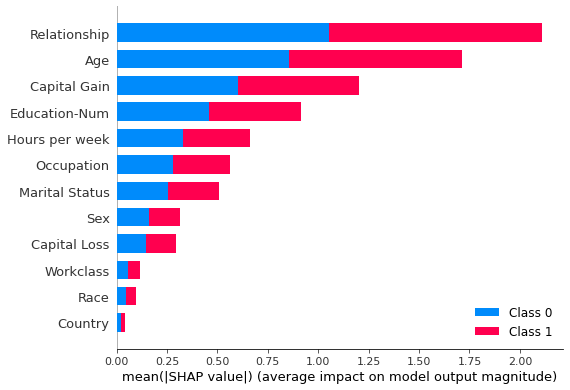

In [36]:
shap.summary_plot(shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


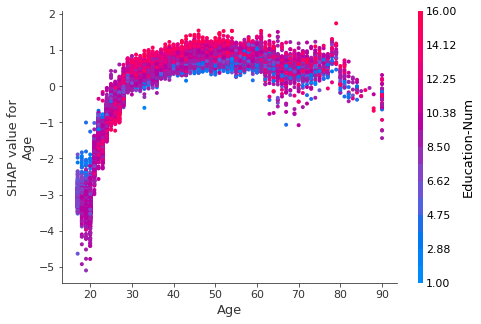

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


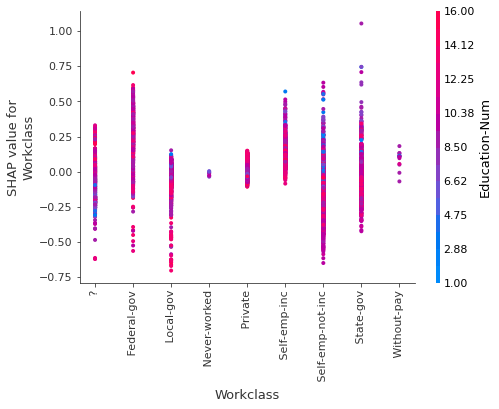

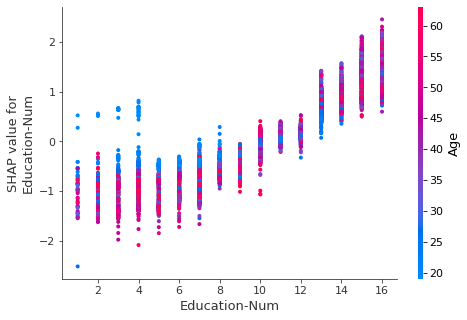

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


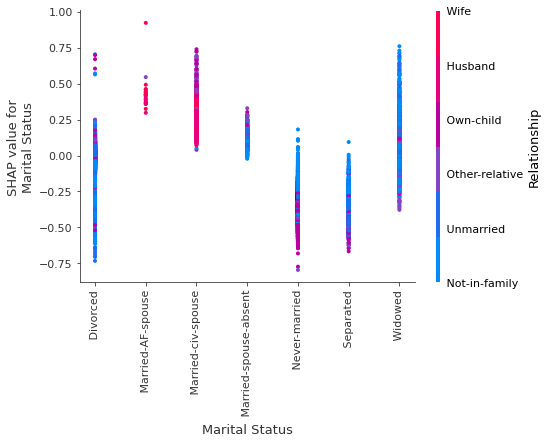

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


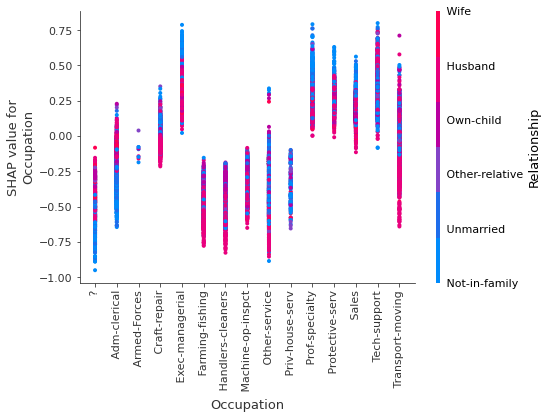

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


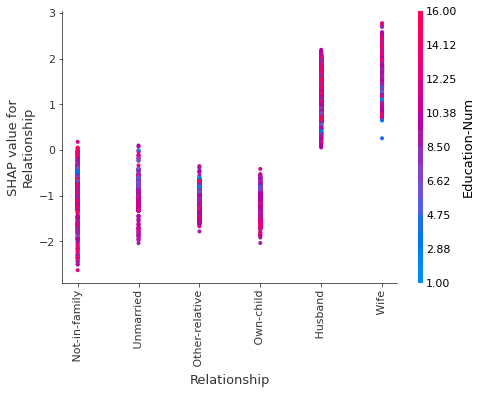

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


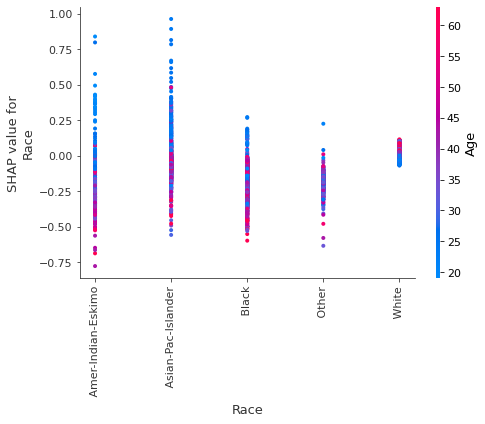

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


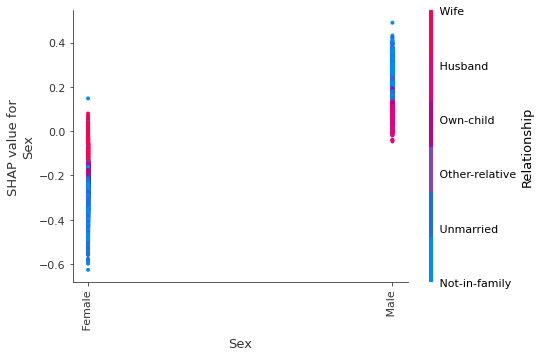

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


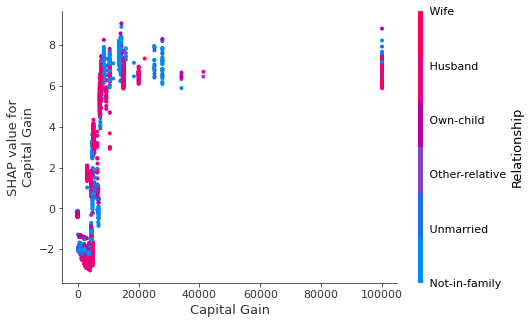

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


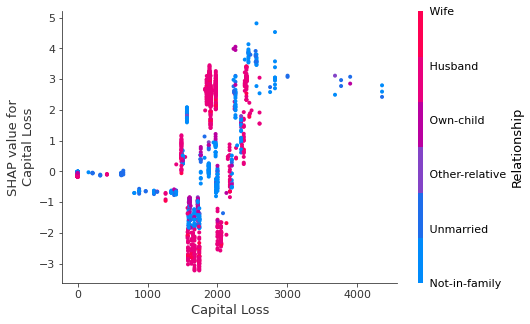

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


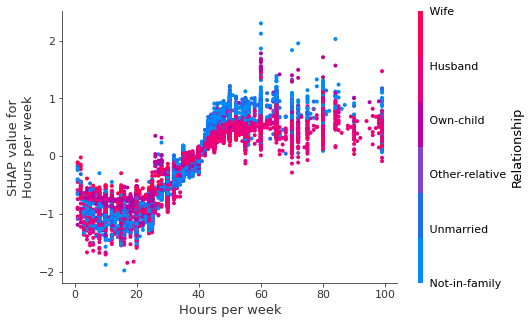

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


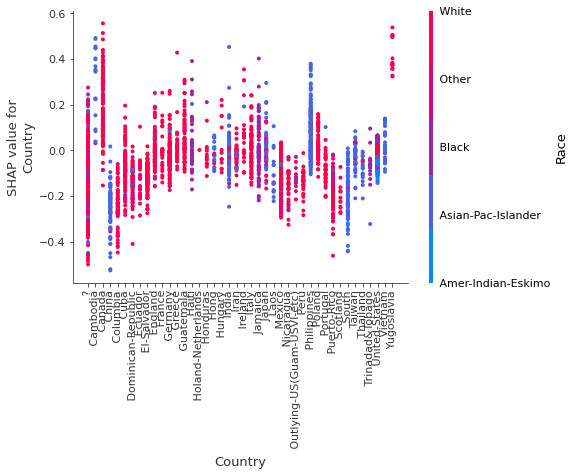

In [37]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)

###  AUTRES --------------


In [18]:
import os
import dill
path = '..\\PICKLES\\P7_04_PyCaret.pkl'

if os.path.exists(path):
    print('----- Model already exists - loading ...')
    with open(path, 'rb') as file:
         dict_models = dill.load(file)
    print('----- Model loaded.')

----- Model already exists - loading ...
----- Model loaded.


In [19]:
dict_models

{'lightgbm': LGBMClassifier(random_state=2556),
 'lda': LinearDiscriminantAnalysis(),
 'rf': RandomForestClassifier(n_jobs=-1, random_state=2556),
 'ada': AdaBoostClassifier(random_state=2556),
 'svm': SGDClassifier(eta0=0.001, n_jobs=-1, random_state=2556)}

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFSampleFilter(BaseEstimator, TransformerMixin):

    def __init__(self, contamination=None, n_neighbors=None, **kwargs):
        self.contamination = contamination if contamination is not None else 0.05
        self.n_neighbors = n_neighbors if n_neighbors is not None else 5
        self.kwargs = kwargs

    def fit(self, X, y=None, *args, **kwargs):
        lcf = LocalOutlierFactor(n_neighbors=self.n_neighbors,
                                 contamination=self.contamination,
                                 **self.kwargs)
        samplefilter = pd.Series(lcf.fit_predict(X))
        samplefilter = samplefilter.replace({1: True, # inliners
                                          -1: False}) # outliers
        # computes the filtered dataframe
        self.X_mod = X.loc[samplefilter.values]
        if y is not None:
            self.y_mod = y.loc[samplefilter.values]
        return self

    def transform(self, X, y=None, copy=None):
        if y is not None:
            return self.X_mod, self.y_mod
        else:
            return self.X_mod

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            return self.fit(X, **fit_params).transform(X)
        else:
            return self.fit(X, y, **fit_params).transform(X,y)


In [ ]:
# return all the scores

def model_scores(y_t, y_p, y_proba, title, df=None):
    
    ser = pd.Series([
                        accuracy_score(y_t, y_p),
                        balanced_accuracy_score(y_t, y_p),
                        recall_score(y_t, y_p),
                        precision_score(y_t, y_p),
                        f1_score(y_t, y_p),
                        fbeta_score(y_t, y_p, beta=5), # favoring recall
                        roc_auc_score(y_t, y_proba),
                        average_precision_score(y_t, y_proba), # area under the pr curve
                        agv_prec_custom(y_t, y_proba), # area under the pr curve, by hand
                        cohen_kappa_score(y_t, y_p),
                        matthews_corrcoef(y_t, y_p),
                        gain_level(y_t, y_p),
                        ],
                        index=['accuracy',
                               'bal_accuracy',
                               'recall_score',
                               'precision_score',
                               'f1_score',
                               'f5_score',
                               'roc_auc_score',
                               'pr_auc_score',
                               'pr_auc_score2',
                               'cohen_kapp',
                               'mcc_score',
                               'gain_level'])
    
    df = pd.DataFrame() if df is None else df
    df[title] = ser
    
    return df

In [ ]:
# GRIDSEARCHCV

# imbalanced pipeline allowing to resample while cross-validating (resampling only in training folds)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8)), # normalisation and encoding
#                     ('outl_filter', LOFSampleFilter()), # outlier cleaning  IsolForestSampleFilte
                    ('resamp', SMOTE(random_state=14)), # resampling
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

# boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100,
# subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0,
# min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0,
# colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 

param_grid = {
              'preproc__strat_binary': ['ord'],
              'preproc__strat_low_card': ['ohe'],
              'preproc__strat_high_card': ['loo'],
              'preproc__strat_quant': ['stand'],
#               'resamp__k_neighbors': [5,10],
#               'outl_filter__contamination': [0.05, 0.1],
              'clf__is_unbalance': [True],
              'clf__n_estimators': [50, 100, 200,500],
#               'clf__num_leaves': [10, 20, 30, 400],
#               'clf__reg_alpha': [0, 0.1],
#               'clf__reg_lambda': [0,0.25,0.5],
#               'clf__learning_rate': [1e-2,5e-2,1e-1],
#               'clf__max_depth' :[-1,3],
                    
              }

             
gs = GridSearchCV(estimator = pipe,
                  param_grid = param_grid,
                  scoring = {'f5_scorer': f5_scorer,
                             'precision': precision_scorer,
                             'recall': recall_scorer,
                             'f1': f1_scorer,
                             'roc_auc': roc_auc_scorer,
                             'gain_factor': gain_factor_scorer,
                             'bal_accuracy': balanced_accuracy_scorer,
                             'kappa': kappa_scorer,
                             'mcc': mcc_scorer,
                             'gain': gain_factor_scorer},
                  # 'precision', 'recall', 'f1', 'roc_auc',  ['recall', 'roc_auc']
                  refit='gain',
                  cv=4,
                  verbose=1,
                  return_train_score=True)
                  

In [ ]:
'''
Pipeline standard
'''

###################################

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

my_cols = ['ORGANIZATION_TYPE', 'CODE_GENDER', 'OCCUPATION_TYPE',
           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'TARGET']
X = X_tr.iloc[:100][['CODE_GENDER', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE',
           'DAYS_BIRTH']]
y = X_tr.iloc[:100]['AMT_INCOME_TOTAL'] 
# X.shape, y.shape


pipe = Pipeline([
                 ('preproc', CustTransformer(thresh_card=8)),
	             ('reg', Ridge()) # ('clf', RidgeClassifier()) # classification
                ])


param_grid = {
              'preproc__strat_binary': ['ord'],
              'preproc__strat_low_card': ['ohe', 'ord'],
              'preproc__strat_high_card': ['ord', 'bin'],
              'preproc__strat_quant': ['stand', 'quant_norm'],
              'reg__alpha': np.logspace(-6,-9, 2)
               }

gs = GridSearchCV(estimator = pipe,
                  param_grid = param_grid,
                  scoring=['r2', 'neg_mean_absolute_error'], #['precision', 'recall', 'f1', 'roc_auc'],
                  refit='r2', #'roc_auc',
                  cv=4,
                  verbose=1,
                  return_train_score=True)

gs.fit(X, y)
# pipe.fit_predict(X)
# gs.best_params_

In [ ]:
# # ENCODING

# import warnings
# warnings.filterwarnings('ignore')

# ct = CustTransformer(thresh_card=7,
#                      strat_quant='stand',
#                      strat_binary='ord',
#                      strat_low_card='ohe',
#                      strat_high_card='loo')

# X_tr_enc = ct.fit_transform(X_tr, y_tr) # y_tris here for 'loo'
# X_tr_enc.shape, X_tr_enc.shape

In [ ]:
# # OUTLIER FILTERING

# isolf_filter = IsolForestSampleFilter(contamination=0.05, n_estimators=100)
# isolf_filter.fit_transform(X_tr_enc).shape

# # zsc_filter = ZscoreSampleFilter(thresh=1, keep='any') # on garde les lignes où toutes les colonnes sont inliers
# # lof_filter = LOFSampleFilter(contamination=0.05, n_neighbors=5)
# # isolf_filter = IsolForestSampleFilter(contamination=0.05, n_estimators=100)
# # zsc_filter.fit_transform(X_tr_enc.iloc[:1000]).shape

In [ ]:
# # RESAMPLING

# sm = SMOTE(sampling_strategy='auto', k_neighbors=5,
#           n_jobs=-1, random_state=14) #'minority'

# X_tr_enc_resamp, y_tr_resamp = sm.fit_resample(X_tr_enc, y_tr)

In [ ]:
#     tp = (y_true==y_pred) & (y_true==1) # true positive
#     tn = (y_true==y_pred) & (y_true==0) # true negative
#     fn = (y_true!=y_pred) & (y_true==1) # false negative
#     fp = (y_true!=y_pred) & (y_true==0) # false positive

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('x', -5, 5)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100);

study.best_params, study.best_value, len(study.trials)#, study.trials, study.best_trial, 

study.optimize(objective, n_trials=100) # continue optimization
len(study.trials), study.best_params, study.best_value, # updated nb of trials